In [1]:
#Develop an image segmentation model using a fully convolutional network.
# The '2018 Data Science Bowl' dataset from kaggle was used - https://www.kaggle.com/competitions/data-science-bowl-2018/data

In [2]:
import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
seed = 42
np.random.seed = seed

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [5]:
TRAIN_PATH = r"C:\Users\To Learn\125156005\Exp4\stage1_train"
TEST_PATH = r"C:\Users\To Learn\125156005\Exp4\stage1_test"

In [6]:
import os

if os.path.isdir(TRAIN_PATH):
    train_ids = next(os.walk(TRAIN_PATH))[1]
else:
    raise FileNotFoundError(f"Directory does not exist: {TRAIN_PATH}")

if os.path.isdir(TEST_PATH):
    test_ids = next(os.walk(TEST_PATH))[1]
else:
    raise FileNotFoundError(f"Directory does not exist: {TEST_PATH}")


In [7]:
X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [8]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (670, 128, 128, 3)
y shape: (670, 128, 128, 1)


In [9]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = os.path.join(TRAIN_PATH, id_)
    
    img_path = os.path.join(path, 'images', f'{id_}.png')
    img = imread(img_path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img.astype(np.uint8)
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(os.path.join(path, 'masks')))[2]:
        mask_path = os.path.join(path, 'masks', mask_file)
        mask_ = imread(mask_path)
        mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        mask = np.maximum(mask, np.expand_dims(mask_, axis=-1))
    
    y[n] = mask.astype(bool)

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [03:25<00:00,  3.25it/s]


In [10]:
test_images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

print('Resizing test images') 

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = os.path.join(TEST_PATH, id_)
    img_path = os.path.join(path, 'images', f'{id_}.png')
    
    if not os.path.exists(img_path):
        print(f'Warning: Image file does not exist at path: {img_path}')
        continue  

    img = imread(img_path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    
    img_resized = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    test_images[n] = img_resized.astype(np.uint8)

print('Done!')

Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 57.73it/s]

Done!


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
len(X_test)

222

In [13]:
len(X_train)

448

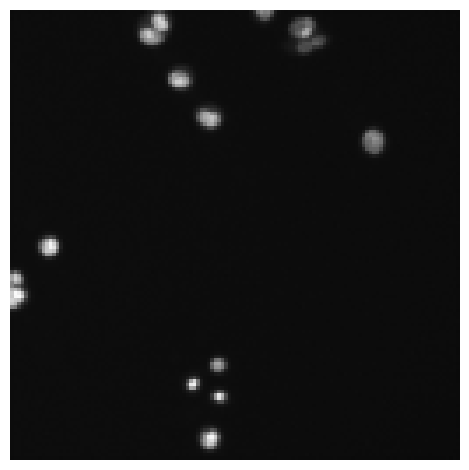

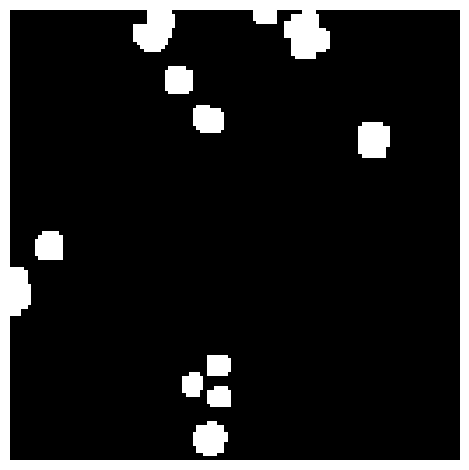

In [14]:
image_x = random.randint(0, len(X_train))
plt.axis("off")
imshow(X_train[image_x])
plt.show()
plt.axis("off")
imshow(np.squeeze(y_train[image_x]))
plt.show()

In [15]:
num_classes = 1

In [16]:
import tensorflow as tf
inputs = tf.keras.layers.Input(shape=(None, None, 3))

In [17]:
print(inputs.shape)

(None, None, None, 3)


In [18]:
def encoder(inputs):
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.2)(c5)
    c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c5)

    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = tf.keras.layers.Dropout(0.3)(c6)
    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    return c6

In [19]:
def decoder(c6):
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Add()([u7, c7])

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Add()([u8, c8])

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Add()([u9, c9])

    u10 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c9)
    c10 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = tf.keras.layers.Add()([u10, c10])

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c10)
    return outputs


In [20]:
encoder = encoder(inputs)
outputs = decoder(encoder)

In [21]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, None, None, 16)    │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, None, None, 16)    │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, None, None, 16)    │           2,320 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, None, None, 16)    │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, None, None, 32)    │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, None, None, 32)    │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, None, None, 32)    │           9,248 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, None, None, 32)    │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, None, None, 64)    │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, None, None, 64)    │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, None, None, 64)    │          36,928 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, None, None, 64)    │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, None, None, 128)   │          73,856 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, None, None, 128)   │               0 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, None, None, 128)   │         147,584 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,995,297 (7.61 MB)

 Trainable params: 1,995,297 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [26]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=16, epochs=40, callbacks=callbacks)

Epoch 1/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.7365 - loss: 0.6258 - val_accuracy: 0.7707 - val_loss: 0.5606
Epoch 2/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.7413 - loss: 0.5698 - val_accuracy: 0.7690 - val_loss: 0.5082
Epoch 3/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.7336 - loss: 0.5536 - val_accuracy: 0.7707 - val_loss: 0.4943
Epoch 4/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.7473 - loss: 0.5240 - val_accuracy: 0.7707 - val_loss: 0.5404
Epoch 5/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.7393 - loss: 0.5381 - val_accuracy: 0.7708 - val_loss: 0.4817
Epoch 6/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.7506 - loss: 0.5155 - val_accuracy: 0.7708 - val_loss: 0.4806
Epoch 7/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.7527 - loss: 0.4999 - val_accuracy: 0.7707 - val_loss: 0.4654
Epoch 8/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.7520 - loss: 0.4887 - val_accuracy: 0.

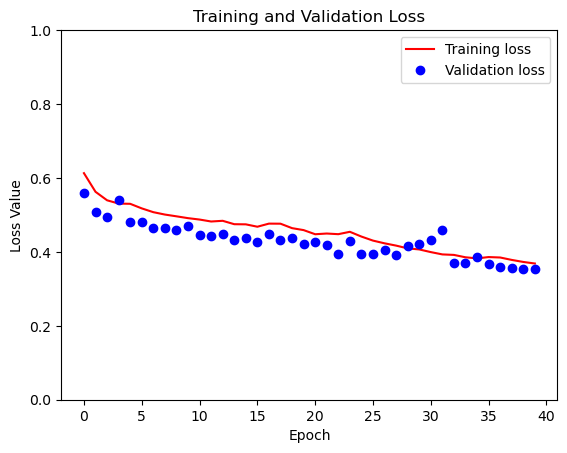

In [27]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

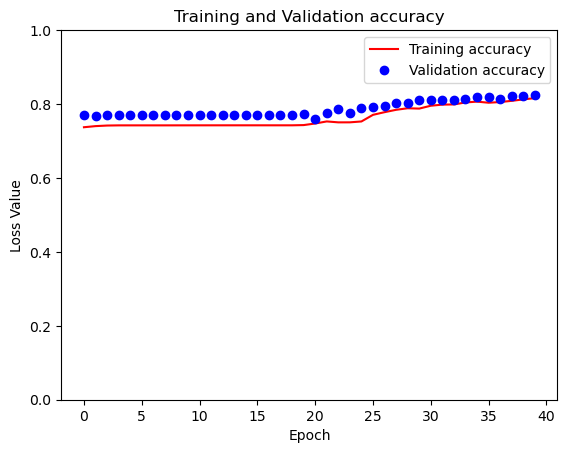

In [28]:
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

plt.figure()
plt.plot( accuracy, 'r', label='Training accuracy')
plt.plot( val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [29]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [35]:
i = random.randint(0, len(X_test))
sample_image = X_test[i]
sample_mask = y_test[i]

In [36]:
predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


In [37]:
prediction = model.predict(sample_image[tf.newaxis, ...])[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [38]:
predicted_mask = (prediction > 0.5).astype(np.uint8)

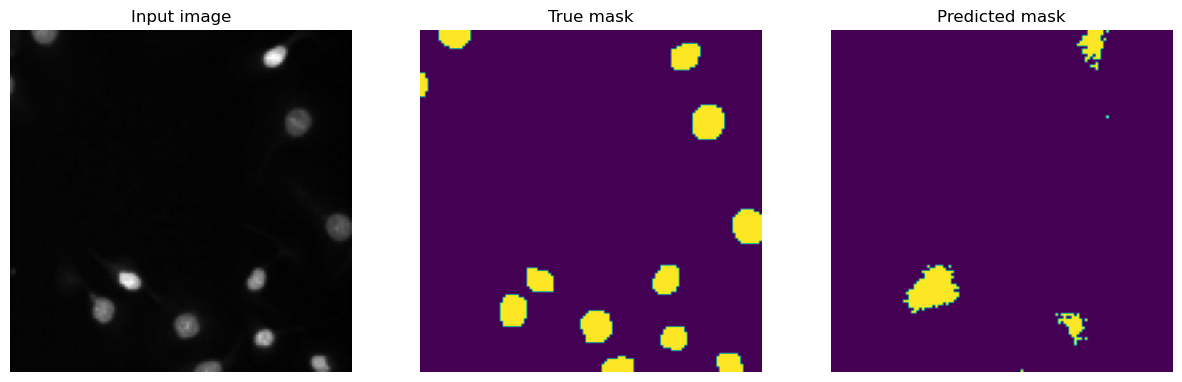

In [39]:
display([sample_image, sample_mask,predicted_mask])